# Clustering: Check-in analysis

### 1. Load and standarize data

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load data
user_features = pd.read_csv("../data/user_features.csv", index_col=0)

# Encoding
gender_mapping = {'Male': 1, 'Female': 2, 'Non-binary': 3}
user_features['gender'] = user_features['gender'].map(gender_mapping)
time_of_day_mapping = {'late night': 1, 'morning': 2, 'afternoon': 3, 'evening': 4, 'night': 5}
user_features['time_of_day_preference'] = user_features['time_of_day_preference'].map(time_of_day_mapping)

# Standardize data
user_features = user_features.drop(columns=user_features.columns[0])
user_features = user_features.drop(columns="seasonal_variability")

scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_features)

# Convert scaled data to df
user_features_scaled = pd.DataFrame(scaled_features, columns=user_features.columns, index=user_features.index)

print(user_features_scaled.head())


   checkin_frequency  time_of_day_preference  workout_diversity  \
0           0.565693               -0.601077           0.020004   
1          -0.932588               -0.601077           0.020004   
2          -0.809730                1.122194           0.020004   
3          -1.908950                1.122194           0.020004   
4          -0.889089               -0.601077           0.020004   

   weekend_preference  avg_workout_duration  checkin_regularity       age  \
0           -0.214570              1.570831           -0.550362  1.096240   
1            0.412173             -1.230326            0.536420 -0.973281   
2            0.952517             -0.021647            0.295681  1.465798   
3            0.101020             -0.632492           -0.756460 -1.638485   
4           -0.515383              1.004210           -0.347950 -0.825458   

     gender  
0  0.561585  
1  2.089290  
2 -0.966121  
3  0.561585  
4  0.561585  


### 2. Visualize data

/tmp/ipykernel_6220/276698796.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  checkin_data = pd.read_csv("../data/_raw/checkin_checkout_history_updated.csv", parse_dates= ['checkin_time', 'checkout_time'])


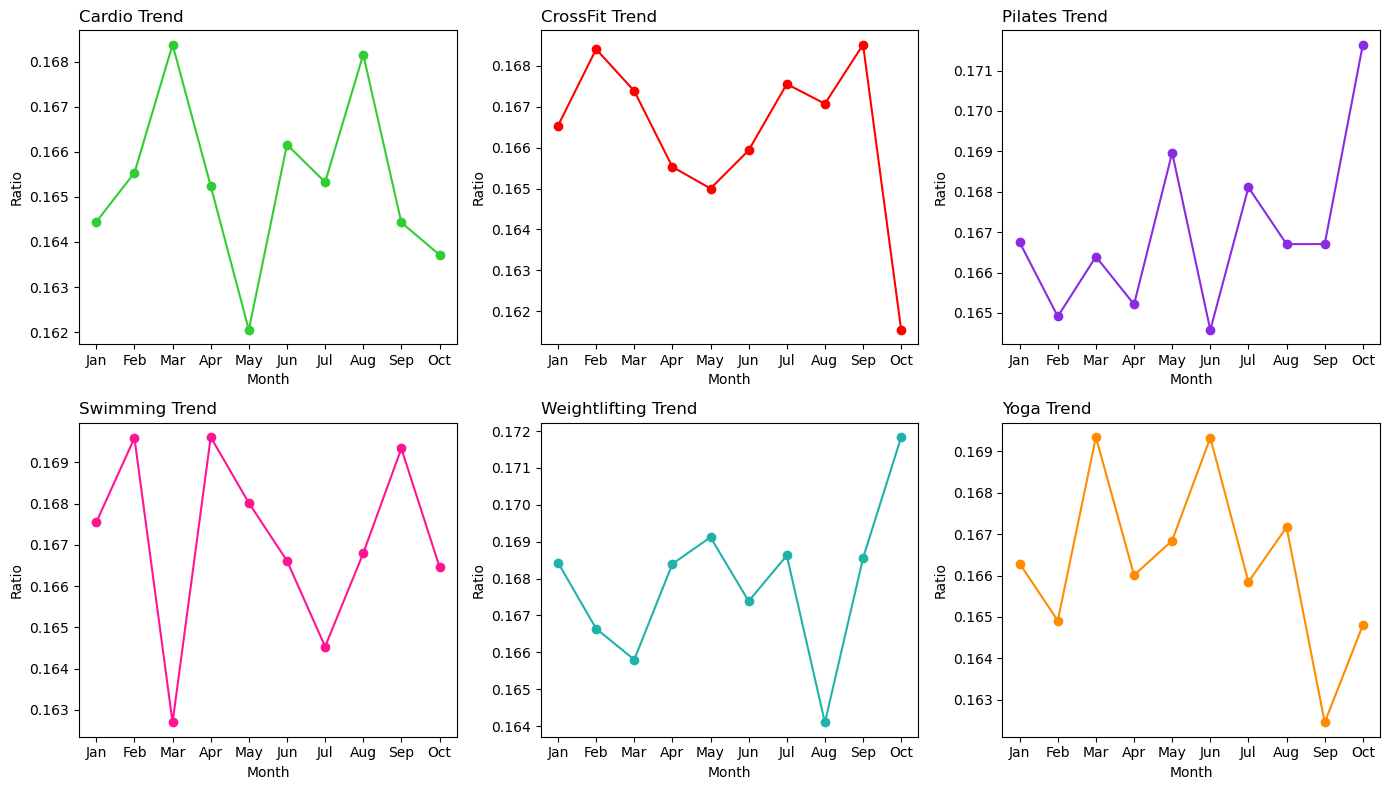

In [63]:
checkin_data = pd.read_csv("../data/_raw/checkin_checkout_history_updated.csv", parse_dates= ['checkin_time', 'checkout_time'])

checkin_data.drop(['calories_burned'], axis = 1, inplace = True) # Remove 'calories_burned' column - not interested to look at
checkin_data['month'] = checkin_data['checkin_time'].dt.month   # Extract month from checkin time   

workout_trends = checkin_data.groupby(['month', 'workout_type']).size().reset_index(name='count') # Count workout types for each month
workout_trends['ratio'] = workout_trends.groupby(
    ['month'])['count'].transform(
        lambda x: x / x.sum()) # Calculating for each month the ratio division of the workouts. 

# Separate plots for each workout
workout_types = workout_trends['workout_type'].unique()

plt.figure(figsize=(14, 8))

# Loop through each workout type
colors = ['darkorange', 'limegreen', 'red', 'blueviolet', 'deeppink', 'lightseagreen']
for i, workout in enumerate(workout_types, start=1):
    # Filter the data for the current workout type
    trend = workout_trends[workout_trends['workout_type'] == workout]
    
    # Create a subplot for each workout type
    plt.subplot(2, 3, i)  # Adjust the grid (2 rows, 3 columns)
    plt.plot(trend['month'], trend['ratio'], marker='o', label=workout, color=colors[i % len(colors)])
    plt.title(f"{workout} Trend", loc='left')
    plt.xlabel('Month')
    plt.ylabel('Ratio')
    plt.xticks(range(1, 11), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])

plt.tight_layout()
plt.savefig('../data/plots/workout_trends.pdf')

### 3. Determining optimal number of clusters

In [39]:
k_values = range(2, 11)

# Initalize scores
inertia_values = [] 
silhouette_scores = []

# For each k alculate inertia and silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_features_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(user_features_scaled, kmeans.labels_))

/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/

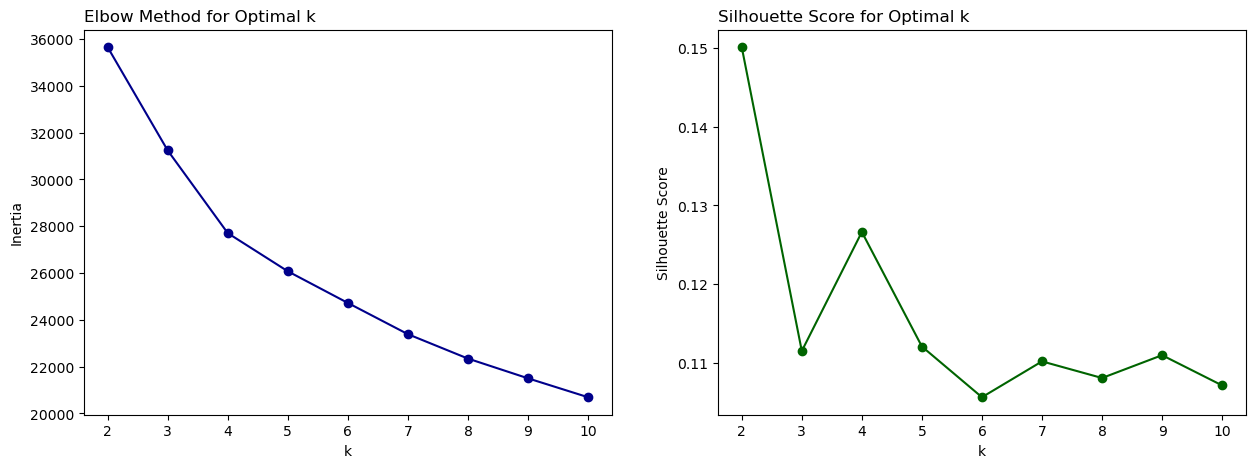

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Elbow method plot
axes[0].plot(k_values, inertia_values, marker='o', color="darkblue")
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k', loc="left")
# Silhouette score plot
axes[1].plot(k_values, silhouette_scores, marker='o', color='darkgreen')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Optimal k', loc="left")
plt.savefig("../data/plots/Optimal_k_plots.pdf")
plt.show()

Based on combination of above plots k = 4 is chosen for further analysis

## K-Means

In [41]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_features_scaled['kmeans_cluster'] = kmeans.fit_predict(user_features_scaled)

# Add cluster labels to user_features df
user_features['kmeans_cluster'] = user_features_scaled['kmeans_cluster']

/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [42]:
cluster_summary = user_features.groupby('kmeans_cluster').mean()

# Display the summary
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
                checkin_frequency  time_of_day_preference  workout_diversity  \
kmeans_cluster                                                                 
0                        6.478104                2.059494                6.0   
1                        6.429684                3.202963                6.0   
2                        6.509805                2.000000                6.0   
3                        5.286675                2.000000                5.0   

                weekend_preference  avg_workout_duration  checkin_regularity  \
kmeans_cluster                                                                 
0                         0.290419            104.596764          118.130229   
1                         0.288774            104.234819          118.510358   
2                         0.288973            104.663568          118.293017   
3                         0.338936            105.754468          109.746351   

                     

In [43]:
# Plot average values of each feature for each cluster
cluster_summary.T.plot(kind='bar', figsize=(10, 8), cmap='plasma')
plt.title("Avg Feature Values by Cluster", loc="left")
plt.ylabel("Average Value")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.savefig("../data/plots/cluster_summary.pdf")
plt.close()


Explained variance by first 2 components: 0.27


/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


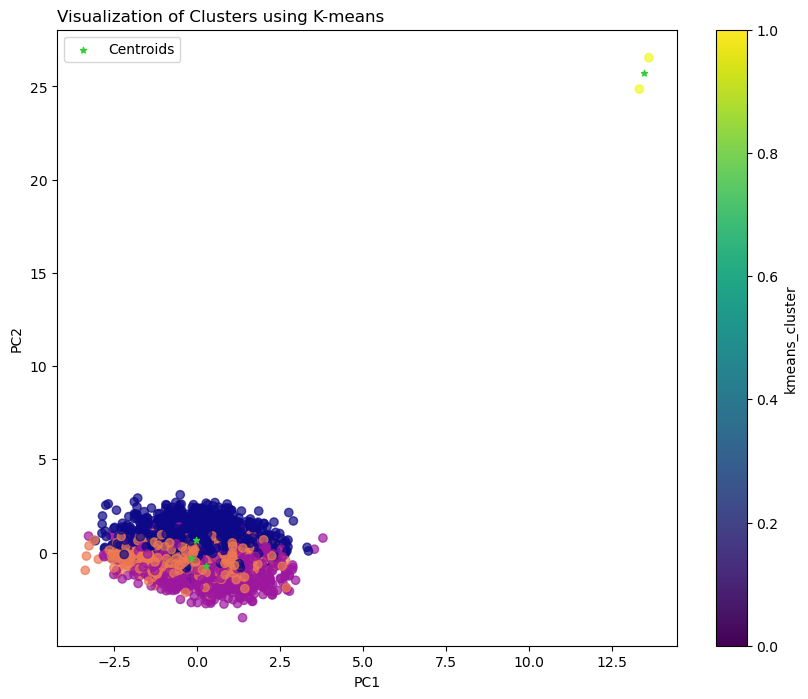

In [35]:


pca = PCA(n_components=2)
pca_components = pca.fit_transform(user_features_scaled.drop('kmeans_cluster', axis=1))

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by first 2 components: {explained_variance.sum():.2f}")

# Plot clusters in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=user_features_scaled['kmeans_cluster'], cmap='plasma', alpha=0.7)

cluster_centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1], c='limegreen', marker='*', s=20, label='Centroids')
plt.legend()

plt.colorbar(label='kmeans_cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of Clusters using K-means', loc="left")
plt.savefig("../data/plots/K_meann_pca2.pdf")
plt.show()

Explained variance by first 3 components: 0.40


/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


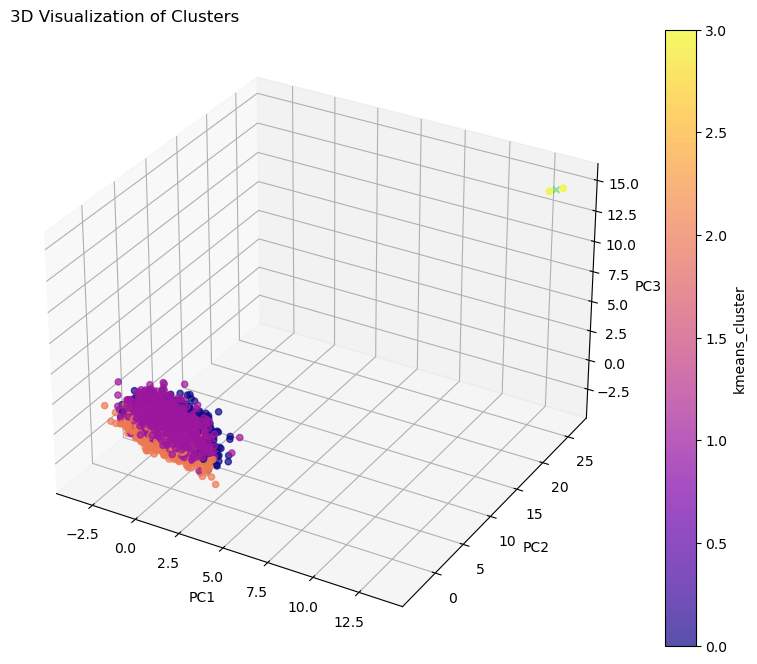

In [44]:


# Perform PCA with 3 components
pca = PCA(n_components=3)
pca_components = pca.fit_transform(user_features_scaled.drop('kmeans_cluster', axis=1))

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by first 3 components: {explained_variance.sum():.2f}")

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_components[:, 0], 
    pca_components[:, 1], 
    pca_components[:, 2], 
    c=user_features_scaled['kmeans_cluster'], 
    cmap='plasma', 
    alpha=0.7
)
cluster_centroids = pca.transform(kmeans.cluster_centers_)
ax.scatter(
    cluster_centroids[:, 0], 
    cluster_centroids[:, 1], 
    cluster_centroids[:, 2], 
    c='limegreen', 
    marker='x', 
    s=20, 
    label='Centroids'
)

# Add labels and color bar
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Visualization of Clusters', loc="left")
fig.colorbar(scatter, ax=ax, label='kmeans_cluster')
plt.savefig("../data/plots/K_meann_pca3.pdf")
plt.show()



In [45]:
silhouette_avg = silhouette_score(user_features_scaled.drop('kmeans_cluster', axis=1), user_features_scaled['kmeans_cluster'])
print(f"Silhouette Score: {silhouette_avg:.3f}")
db_index = davies_bouldin_score(user_features_scaled.drop('kmeans_cluster', axis=1), user_features_scaled['kmeans_cluster'])
print(f"Davies-Bouldin Index: {db_index:.3f}")

#Get poor scores, trying with DBSCAN instead

Silhouette Score: 0.127
Davies-Bouldin Index: 1.705


## DBSCAN

   checkin_frequency  time_of_day_preference  workout_diversity  \
0           0.565693               -0.601077           0.020004   
1          -0.932588               -0.601077           0.020004   
2          -0.809730                1.122194           0.020004   
3          -1.908950                1.122194           0.020004   
4          -0.889089               -0.601077           0.020004   

   weekend_preference  avg_workout_duration  checkin_regularity       age  \
0           -0.214570              1.570831           -0.550362  1.096240   
1            0.412173             -1.230326            0.536420 -0.973281   
2            0.952517             -0.021647            0.295681  1.465798   
3            0.101020             -0.632492           -0.756460 -1.638485   
4           -0.515383              1.004210           -0.347950 -0.825458   

     gender  kmeans_cluster  
0  0.561585               0  
1  2.089290               0  
2 -0.966121               1  
3  0.561585   

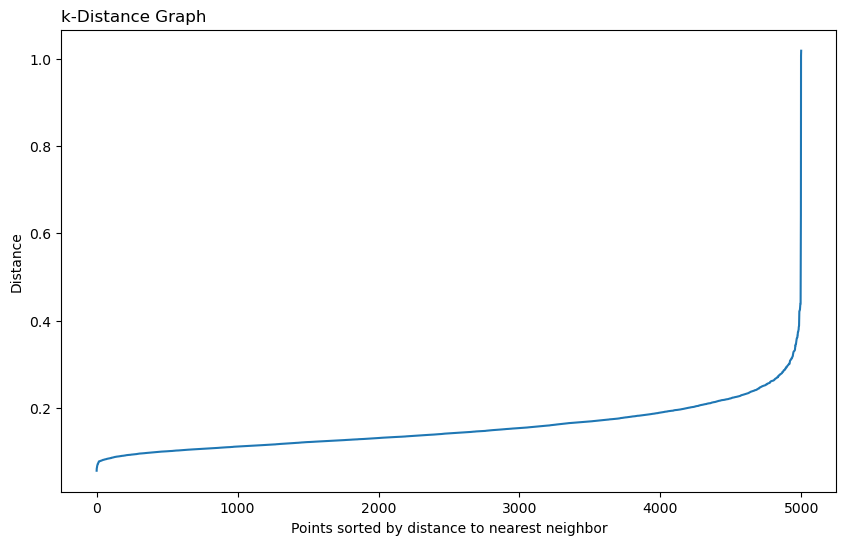

In [51]:
# DBSCAN: Identify Optimal Epsilon using k-distance graph
normalizer = MinMaxScaler()
normalized_features = normalizer.fit_transform(user_features_scaled.drop(columns='kmeans_cluster', axis=1))

print(user_features_scaled.head(5))

# Find optimal epsilon
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = nearest_neighbors.fit(normalized_features)
distances, indices = neighbors_fit.kneighbors(normalized_features)

# Sort distances for k-distance graph
distances = np.sort(distances[:, -1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-Distance Graph', loc="left")
plt.xlabel('Points sorted by distance to nearest neighbor')
plt.ylabel('Distance')
plt.savefig("../data/plots/k_distance_graph.pdf")
plt.show()

Looks like epsilon = 0.3 is optimal

In [54]:
# DBSCAN parameters
eps = 0.3  
min_samples = 5  

# DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(normalized_features)
normalized_df = pd.DataFrame(normalized_features, 
                             columns=user_features_scaled.drop(columns=['kmeans_cluster'], errors='ignore').columns, 
                             index=user_features_scaled.index)
normalized_df['dbscan_cluster'] = dbscan_labels
filtered_data = normalized_df[normalized_df['dbscan_cluster'] != -1].copy()
print(normalized_df['dbscan_cluster'].value_counts())
cluster_summary = normalized_df.groupby('dbscan_cluster').mean()
print(cluster_summary)

dbscan_cluster
 5    1630
 0    1553
 2     569
 3     507
 1     343
 7     124
 4     118
 6     113
-1      33
 8       6
 9       4
Name: count, dtype: int64
                checkin_frequency  time_of_day_preference  workout_diversity  \
dbscan_cluster                                                                 
-1                       0.401908                0.848485           0.939394   
 0                       0.453112                0.000000           1.000000   
 1                       0.459045                0.000000           1.000000   
 2                       0.440973                0.500000           1.000000   
 3                       0.447013                0.500000           1.000000   
 4                       0.432687                0.500000           1.000000   
 5                       0.458247                0.000000           1.000000   
 6                       0.438288                1.000000           1.000000   
 7                       0.455544     

# Insights

Cluster -1: Noise points. Irregular users, gender-balanced, late-night preferences <br>
Cluster 0: time_of_day_preference is 0.00 indicating morning workouts. Moderate frequency, male-skewed, prefer mornings <br>
Cluster 1: checkin_freq 0.46, avg_work_dur 0.51, morning pref, Regular attendance, female-skewed, prefer mornings <br>
Cluster 2: **Profile:** Moderate frequency, male-dominant, prefer afternoons <br>
Cluster 3: Balanced gender, prefer afternoons 
Cluster 4: Consistent, female-skewed, prefer evenings <br>
Cluster 5: High frequency, male-skewed, prefer mornings <br>
Cluster 6: Balanced gender, prefer late-night workouts <br>
Cluster 7: Moderate frequency, male-skewed, prefer weekends <br>
Cluster 8: Rare, female-skewed, prefer late-night workouts <br>
Cluster 9: Minimal users, female-skewed, prefer night workouts <br>

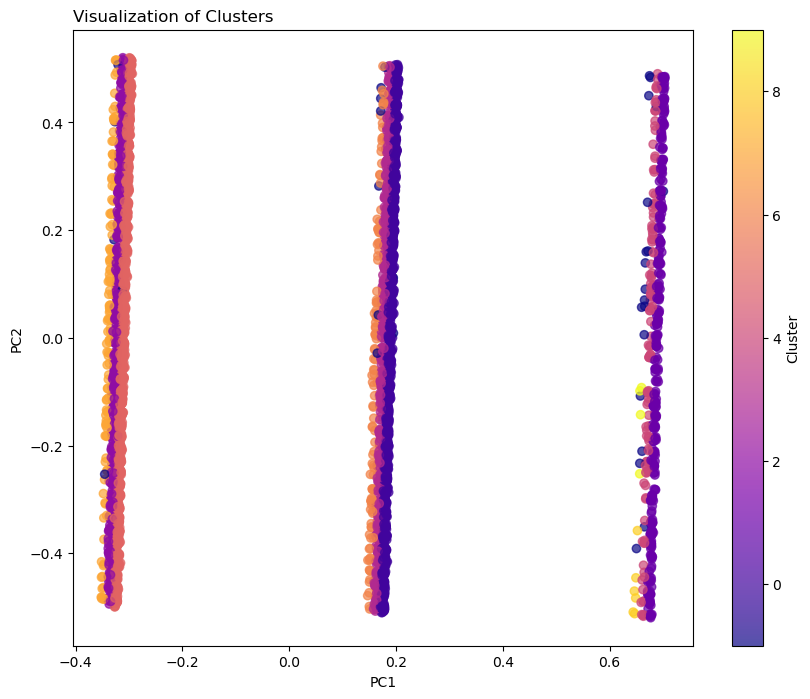

In [56]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(normalized_df.drop(['dbscan_cluster'], axis=1))

# Plot clusters in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=normalized_df['dbscan_cluster'], cmap='plasma', alpha=0.7)
plt.colorbar(label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of Clusters', loc="left")
plt.savefig("../data/plots/DBSCAN_pca2.pdf")
plt.show()


In [57]:
print(normalized_df.columns)


Index(['checkin_frequency', 'time_of_day_preference', 'workout_diversity',
       'weekend_preference', 'avg_workout_duration', 'checkin_regularity',
       'age', 'gender', 'dbscan_cluster'],
      dtype='object')


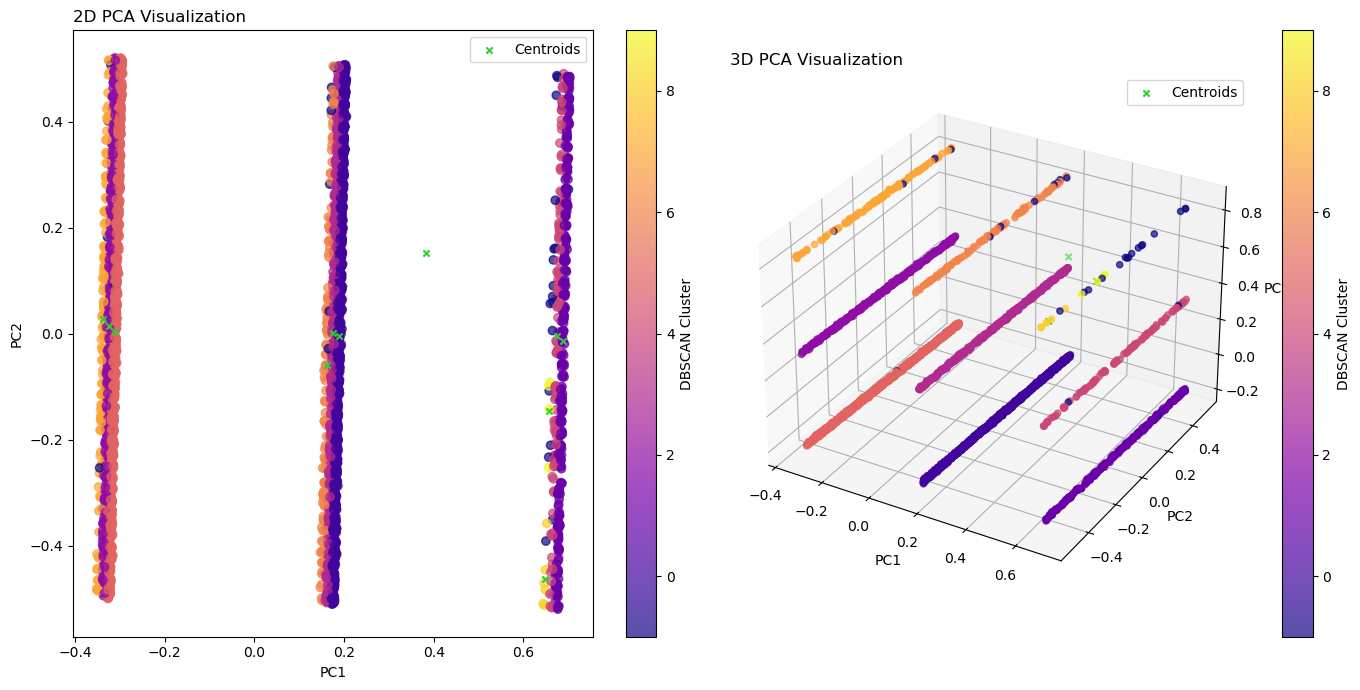

Explained variance for 2D PCA: 0.56
Explained variance for 3D PCA: 0.80


In [58]:
features_for_pca = normalized_df.drop(columns=['dbscan_cluster'], errors='ignore')

pca_2d = PCA(n_components=2)
pca_2d_components = pca_2d.fit_transform(features_for_pca)
pca_2d_variance = pca_2d.explained_variance_ratio_

# Perform PCA for 3D visualization
pca_3d = PCA(n_components=3)
pca_3d_components = pca_3d.fit_transform(features_for_pca)
pca_3d_variance = pca_3d.explained_variance_ratio_

# Calculate cluster centroids in PCA space
dbscan_centroids = normalized_df.groupby('dbscan_cluster').mean().drop(columns=['dbscan_cluster'], errors='ignore')
pca_2d_centroids = pca_2d.transform(dbscan_centroids)
pca_3d_centroids = pca_3d.transform(dbscan_centroids)

# Create subplots for 2D and 3D PCA
fig = plt.figure(figsize=(14, 7))

# 2D PCA Plot
ax1 = fig.add_subplot(121)
scatter_2d = ax1.scatter(
    pca_2d_components[:, 0], pca_2d_components[:, 1],
    c=normalized_df['dbscan_cluster'], cmap='plasma', alpha=0.7
)
ax1.scatter(
    pca_2d_centroids[:, 0], pca_2d_centroids[:, 1],
    c='limegreen', marker='x', s=20, label='Centroids'
)
ax1.set_title('2D PCA Visualization', loc='left')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend()
fig.colorbar(scatter_2d, ax=ax1, label='DBSCAN Cluster')

# 3D PCA Plot
ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(
    pca_3d_components[:, 0], pca_3d_components[:, 1], pca_3d_components[:, 2],
    c=normalized_df['dbscan_cluster'], cmap='plasma', alpha=0.7
)
ax2.scatter(
    pca_3d_centroids[:, 0], pca_3d_centroids[:, 1], pca_3d_centroids[:, 2],
    c='limegreen', marker='x', s=20, label='Centroids'
)
ax2.set_title('3D PCA Visualization', loc='left')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend()
fig.colorbar(scatter_3d, ax=ax2, label='DBSCAN Cluster')

plt.tight_layout()
plt.savefig("../data/plots/DBSCAN_clusters.pdf")
plt.show()

# Print explained variance ratios
print(f"Explained variance for 2D PCA: {pca_2d_variance.sum():.2f}")
print(f"Explained variance for 3D PCA: {pca_3d_variance.sum():.2f}")

In [59]:
cluster_labels = normalized_df['dbscan_cluster']
features = normalized_df.drop(columns=['dbscan_cluster'], errors='ignore')

# Remove noise points
filtered_features = features[cluster_labels != -1]
filtered_labels = cluster_labels[cluster_labels != -1]

silhouette_avg = silhouette_score(filtered_features, filtered_labels)
davies_bouldin = davies_bouldin_score(filtered_features, filtered_labels)
print(f"Silhouette Score (excluding noise): {silhouette_avg:.2f}")
print(f"Davies-Bouldin Index (excluding noise): {davies_bouldin:.2f}")

Silhouette Score (excluding noise): 0.28
Davies-Bouldin Index (excluding noise): 1.41


# Below is not used in report, just a test to see how it looked. 

### Aggliomerative Clustering

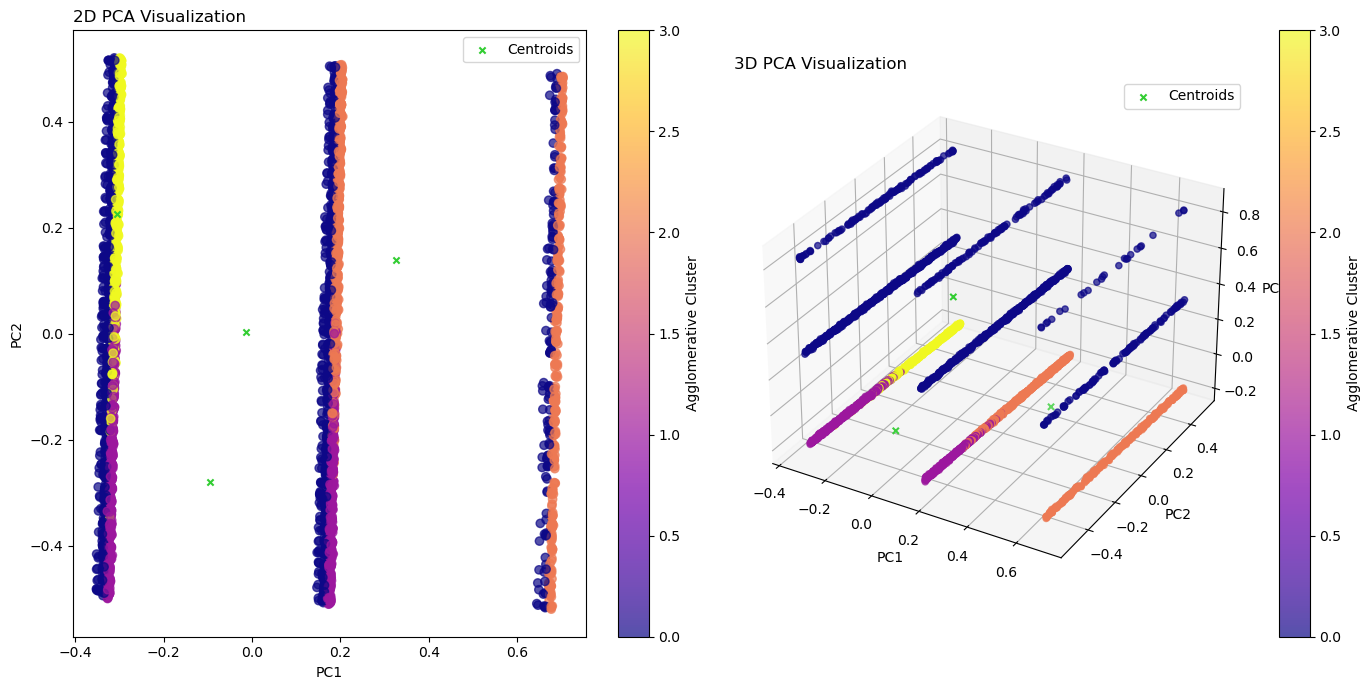

Explained variance for 2D PCA: 0.56
Explained variance for 3D PCA: 0.80


In [81]:
from sklearn.cluster import AgglomerativeClustering

# Set the number of clusters
n_clusters = 4

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg_clustering.fit_predict(normalized_df.drop(['dbscan_cluster'], axis=1))

# Add the cluster labels to the dataframe
normalized_df['agg_cluster'] = agg_labels

features_for_pca = normalized_df.drop(columns=['dbscan_cluster', "agg_cluster"], errors='ignore')

pca_2d = PCA(n_components=2)
pca_2d_components = pca_2d.fit_transform(features_for_pca)
pca_2d_variance = pca_2d.explained_variance_ratio_

# Perform PCA for 3D visualization
pca_3d = PCA(n_components=3)
pca_3d_components = pca_3d.fit_transform(features_for_pca)
pca_3d_variance = pca_3d.explained_variance_ratio_

# Calculate cluster centroids in PCA space
dbscan_centroids = normalized_df.groupby('agg_cluster').mean().drop(columns=['dbscan_cluster', "agg_cluster"], errors='ignore')
pca_2d_centroids = pca_2d.transform(dbscan_centroids)
pca_3d_centroids = pca_3d.transform(dbscan_centroids)

# Create subplots for 2D and 3D PCA
fig = plt.figure(figsize=(14, 7))

# 2D PCA Plot
ax1 = fig.add_subplot(121)
scatter_2d = ax1.scatter(
    pca_2d_components[:, 0], pca_2d_components[:, 1],
    c=normalized_df['agg_cluster'], cmap='plasma', alpha=0.7
)
ax1.scatter(
    pca_2d_centroids[:, 0], pca_2d_centroids[:, 1],
    c='limegreen', marker='x', s=20, label='Centroids'
)
ax1.set_title('2D PCA Visualization', loc='left')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend()
fig.colorbar(scatter_2d, ax=ax1, label='Agglomerative Cluster')

# 3D PCA Plot
ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(
    pca_3d_components[:, 0], pca_3d_components[:, 1], pca_3d_components[:, 2],
    c=normalized_df['agg_cluster'], cmap='plasma', alpha=0.7
)
ax2.scatter(
    pca_3d_centroids[:, 0], pca_3d_centroids[:, 1], pca_3d_centroids[:, 2],
    c='limegreen', marker='x', s=20, label='Centroids'
)
ax2.set_title('3D PCA Visualization', loc='left')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend()
fig.colorbar(scatter_3d, ax=ax2, label='Agglomerative Cluster')

plt.tight_layout()
plt.savefig("../data/plots/agg_clusters.pdf")
plt.show()

# Print explained variance ratios
print(f"Explained variance for 2D PCA: {pca_2d_variance.sum():.2f}")
print(f"Explained variance for 3D PCA: {pca_3d_variance.sum():.2f}")

In [82]:
cluster_labels = normalized_df['agg_cluster']
features = normalized_df.drop(columns=['dbscan_cluster', "agg_cluster"], errors='ignore')

silhouette_avg = silhouette_score(features, cluster_labels)
davies_bouldin = davies_bouldin_score(features, cluster_labels)
print(f"Silhouette Score (excluding noise): {silhouette_avg:.2f}")
print(f"Davies-Bouldin Index (excluding noise): {davies_bouldin:.2f}")

Silhouette Score (excluding noise): 0.18
Davies-Bouldin Index (excluding noise): 1.34


Not great, huh